<a href="https://colab.research.google.com/github/IT21162428/Research---Digital-Companion/blob/IT21338984_Imesh/AgeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1.Setup and Load Data**

##### 1.1 Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiohappyeyeballs                   2.4.3
aiohttp                            3.11.2
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.6
astropy-iers-data                  0.2024.11.18.0.35.2
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread           

In [3]:
import tensorflow as tf
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('CPU')

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


##### 1.2 Remove dodgy images

In [6]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [7]:
data_dir = '/content/drive/MyDrive/RESEARCH/dataset/ChildrenAdults/train'

In [8]:
os.listdir(data_dir)

['adults', 'children']

In [9]:
image_exts = ['jpeg','jpg','bmp','png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 680 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
# Get another batch from the iterator
batch = data_iterator.next()

In [15]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [16]:
# Class 1 = Children
# Class 0 = Adults
batch[1]

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

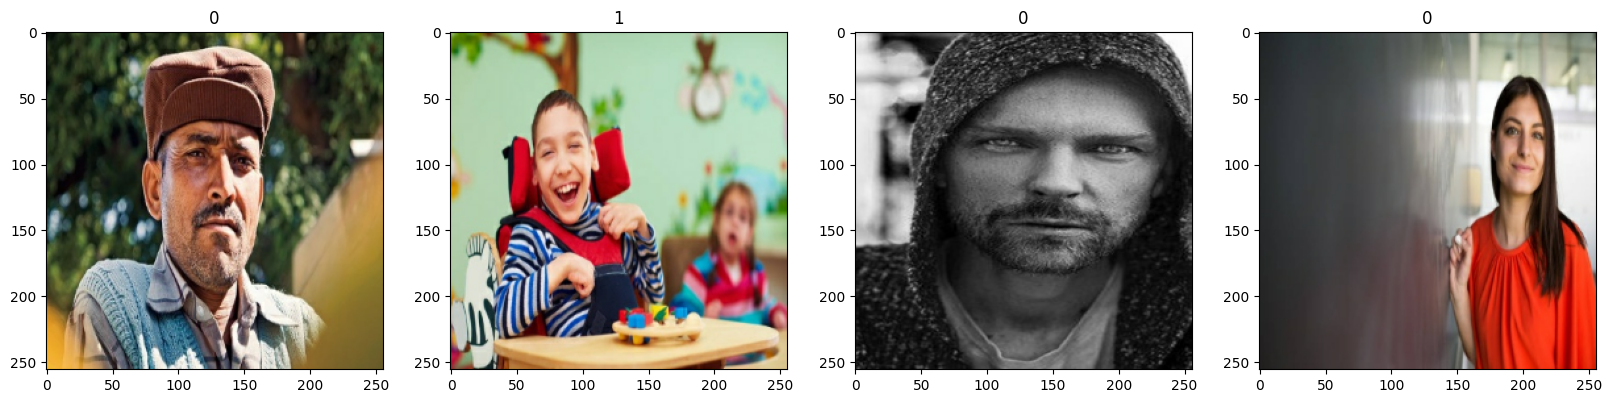

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
scaled = batch[0] / 255

In [19]:
scaled.max()

1.0

### **2. Preprocess Data**

##### 2.1 Scale Data

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
data.as_numpy_iterator().next()[0].max()

1.0

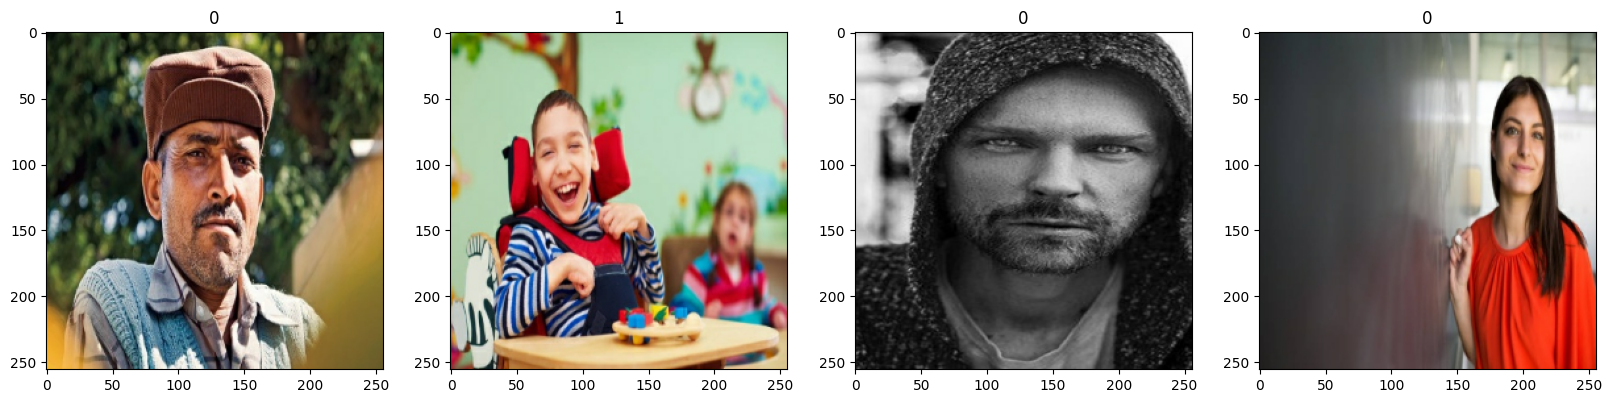

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##### 2.2 Split Data

In [23]:
len(data)

22

In [26]:
22*.7

15.399999999999999

In [27]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [28]:
train_size+val_size+test_size

22

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [30]:
len(test)

2

###**3. Deep Model**

##### 3.1 Build Deep Learmimg Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [32]:
model = Sequential()

In [33]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

##### 3.2 Train

In [38]:
logdir= '/content/drive/MyDrive/RESEARCH/logs/age'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4690 - loss: 1.0203 - val_accuracy: 0.5063 - val_loss: 0.6890
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4849 - loss: 0.6937 - val_accuracy: 0.5688 - val_loss: 0.6817
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5639 - loss: 0.6802 - val_accuracy: 0.6625 - val_loss: 0.6667
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6458 - loss: 0.6606 - val_accuracy: 0.6562 - val_loss: 0.6221
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6876 - loss: 0.5833 - val_accuracy: 0.7625 - val_loss: 0.5053
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8427 - loss: 0.4532 - val_accuracy: 0.8375 - val_loss: 0.4494
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8723 - loss: 0.3557 - val_accuracy: 0.8500 - val_loss: 0.3476
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9160 - loss: 0.2462 - val_accuracy: 0.8438 - val_loss:

##### 3.3 Plot Performance

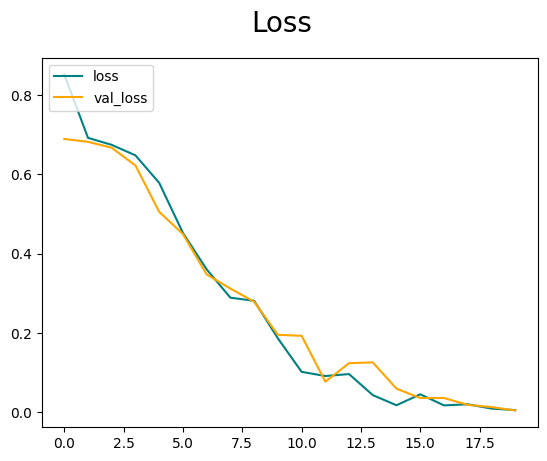

In [41]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

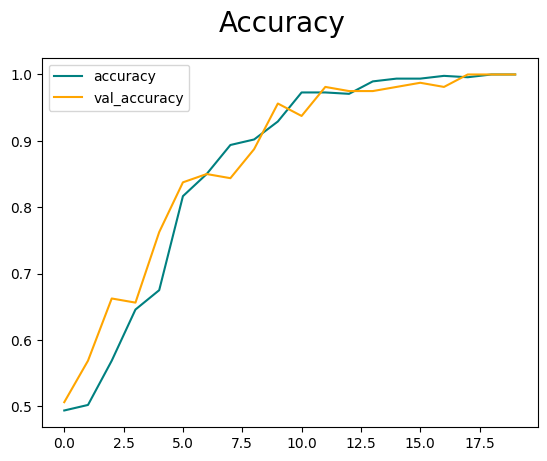

In [42]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4. **Evaluate Performance**

##### 4.1 Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [45]:
for Batch in test.as_numpy_iterator():
  x, y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


In [46]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


##### 4.2 Test

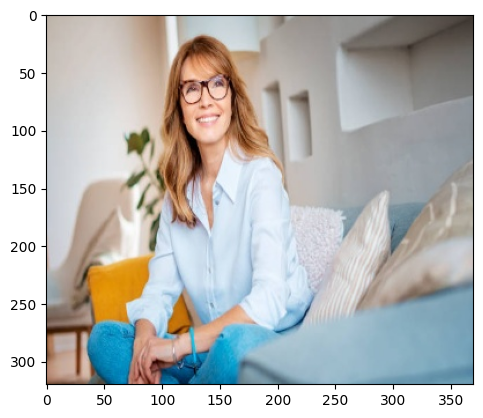

In [65]:
img = cv2.imread('/content/drive/MyDrive/RESEARCH/20.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

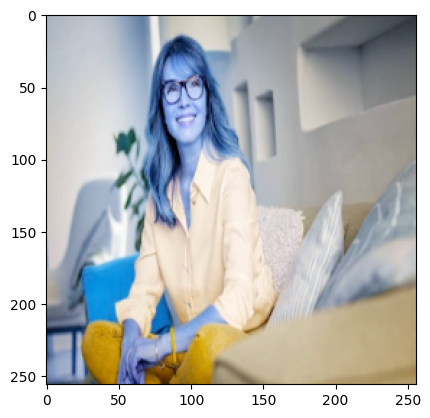

In [66]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
resize.shape

TensorShape([256, 256, 3])

In [68]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [69]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [70]:
yhat

array([[0.8877506]], dtype=float32)

In [71]:
if yhat < 0.5:
  print(f'Predicted class is Children')
else:
  print(f'Predicted class is Adult')

Predicted class is Adult


### 5. Save the Model

##### 5.1 Save the Model

In [72]:
from tensorflow.keras.models import load_model

In [73]:
model.save(os.path.join('/content/drive/MyDrive/RESEARCH/models','ageClassification.h5'))

In [62]:
new_model = load_model(os.path.join('/content/drive/MyDrive/RESEARCH/models','ageClassification.h5'))

In [63]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [74]:
if yhat < 0.5:
  print(f'Predicted class is Children')
else:
  print(f'Predicted class is Adult')

Predicted class is Adult
